In [1]:
!pip install transformers torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 25.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
!pip install wordcloud seaborn nltk scikit-learn joblib tqdm


In [3]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")


PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU device: Tesla T4


In [15]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import sys
import warnings
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # or just tqdm if notebook throws an error
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.optim import AdamW


# 📍 Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 🧹 Warnings
warnings.filterwarnings('ignore')

# 🧠 NLTK Downloads
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# ✨ Preprocessing Class
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()

    def clean_text(self, text):
        if pd.isna(text):
            return ""
        text = text.lower()
        text = re.sub(r"http\S+|www\S+|https\S+", "", text)
        text = re.sub(r"@\w+|#\w+", "", text)
        text = re.sub(r"[^\w\s!?]", " ", text)
        text = re.sub(r"\d+", "", text)
        text = re.sub(r"\s+", " ", text).strip()
        return text

    def preprocess_text(self, text):
        text = self.clean_text(text)
        words = text.split()
        filtered = [self.stemmer.stem(word) for word in words if word not in self.stop_words and len(word) > 2]
        return " ".join(filtered)

# 📥 Load Dataset
def load_full_data(file_path='steam_reviews.csv'):
    print(f"📥 Loading dataset from '{file_path}'...")

    if not os.path.exists(file_path):
        print(f"❌ File not found: {file_path}")
        sys.exit(1)

    try:
        df = pd.read_csv(file_path)

        if 'recommendation' in df.columns:
            df['sentiment_label'] = (df['recommendation'].str.strip() == 'Recommended').astype(int)
        elif 'recommend' in df.columns:
            df['sentiment_label'] = df['recommend'].map({True: 1, False: 0})
        else:
            raise ValueError("❌ Dataset must contain either 'recommendation' or 'recommend' column.")

        df = df.dropna(subset=['review'])
        df['review'] = df['review'].astype(str)

        print(f"✅ Loaded {len(df)} reviews")
        print("📊 Sentiment Distribution:")
        print(df['sentiment_label'].value_counts())

        return df

    except Exception as e:
        print(f"❌ Error loading dataset: {e}")
        sys.exit(1)

# 🚀 Load and Preprocess All Data
print("🔁 Loading and preprocessing full dataset...")

df_raw = load_full_data('steam_reviews.csv')

if df_raw is not None:
    preprocessor = TextPreprocessor()
    df_raw['processed_review'] = df_raw['review'].apply(preprocessor.preprocess_text)

    df_raw.to_csv("steam_reviews_cleaned_full.csv", index=False)
    print("💾 Saved full preprocessed dataset as 'steam_reviews_cleaned_full.csv'")


🔁 Loading and preprocessing full dataset...
📥 Loading dataset from 'steam_reviews.csv'...
✅ Loaded 19931 reviews
📊 Sentiment Distribution:
sentiment_label
1    14005
0     5926
Name: count, dtype: int64
💾 Saved full preprocessed dataset as 'steam_reviews_cleaned_full.csv'


In [16]:
# 🖨️ View Processed Data Head
print("📄 First few rows of the preprocessed dataset:")
print(df_raw[['review', 'processed_review', 'sentiment_label']].head())


📄 First few rows of the preprocessed dataset:
                                              review  \
0  Pretty much same controls and buggy mess as al...   
1                          game cant even find stone   
2  EVERY DRAGON NEED A BLOOD BAR !!!!!!!! I spend...   
3  Great game. Just not into the whole open world...   
4  People compare this game to dark souls but it ...   

                                    processed_review  sentiment_label  
0    pretti much control buggi mess battl royal game                0  
1                          game cant even find stone                0  
2  everi dragon need blood bar !!!!!!!! spend min...                0  
3          great game whole open world type gameplay                0  
4  peopl compar game dark soul similar dark soul ...                0  


In [17]:
# Cell 2: Dataset Class and Utility Functions

class SentimentDataset(Dataset):
    """
    Custom PyTorch Dataset for sentiment classification.
    """
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def plot_training_curves(train_losses, val_accuracies, val_f1_scores):
    """Plot training curves for monitoring."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Training loss
    ax1.plot(train_losses, 'b-', label='Training Loss')
    ax1.set_title('Training Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Validation metrics
    ax2.plot(val_accuracies, 'g-', label='Validation Accuracy')
    ax2.plot(val_f1_scores, 'r-', label='Validation F1-Score')
    ax2.set_title('Validation Metrics Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

print("✅ Dataset class and utility functions defined!")

✅ Dataset class and utility functions defined!


In [19]:
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")


🖥️ Using device: cuda


🎬 Starting training with raw data...
🚀 Starting Improved DistilBERT Training with Raw Data...
📊 Training with 19931 samples
📊 Label distribution: {1: 14005, 0: 5926}
📊 Split sizes:
  Training: 13951
  Validation: 1993
  Test: 3987


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



⚙️ Training Configuration:
  Epochs: 4
  Batch Size: 16
  Learning Rate: 2e-05
  Max Length: 256
  Total Steps: 3488
  Warmup Steps: 348

📚 Epoch 1/4


Training:   0%|          | 0/872 [00:00<?, ?it/s]

Validation:   0%|          | 0/125 [00:00<?, ?it/s]

🎯 New best model! Val F1: 0.9072
Epoch 1 Results:
  Train Loss: 0.4166
  Val Accuracy: 0.8630
  Val F1: 0.9072
  Val Precision: 0.8652
  Val Recall: 0.9536

📚 Epoch 2/4


Training:   0%|          | 0/872 [00:00<?, ?it/s]

Validation:   0%|          | 0/125 [00:00<?, ?it/s]

🎯 New best model! Val F1: 0.9193
Epoch 2 Results:
  Train Loss: 0.2768
  Val Accuracy: 0.8851
  Val F1: 0.9193
  Val Precision: 0.9074
  Val Recall: 0.9314

📚 Epoch 3/4


Training:   0%|          | 0/872 [00:00<?, ?it/s]

Validation:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3 Results:
  Train Loss: 0.2200
  Val Accuracy: 0.8821
  Val F1: 0.9168
  Val Precision: 0.9088
  Val Recall: 0.9250

📚 Epoch 4/4


Training:   0%|          | 0/872 [00:00<?, ?it/s]

Validation:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4 Results:
  Train Loss: 0.1835
  Val Accuracy: 0.8796
  Val F1: 0.9150
  Val Precision: 0.9073
  Val Recall: 0.9229

✅ Loaded best model with Val F1: 0.9193

🎯 Final Test Set Evaluation:


Testing:   0%|          | 0/250 [00:00<?, ?it/s]

Final Test Results:
  Test Accuracy: 0.8856
  Test F1: 0.9194
  Test Precision: 0.9110
  Test Recall: 0.9279


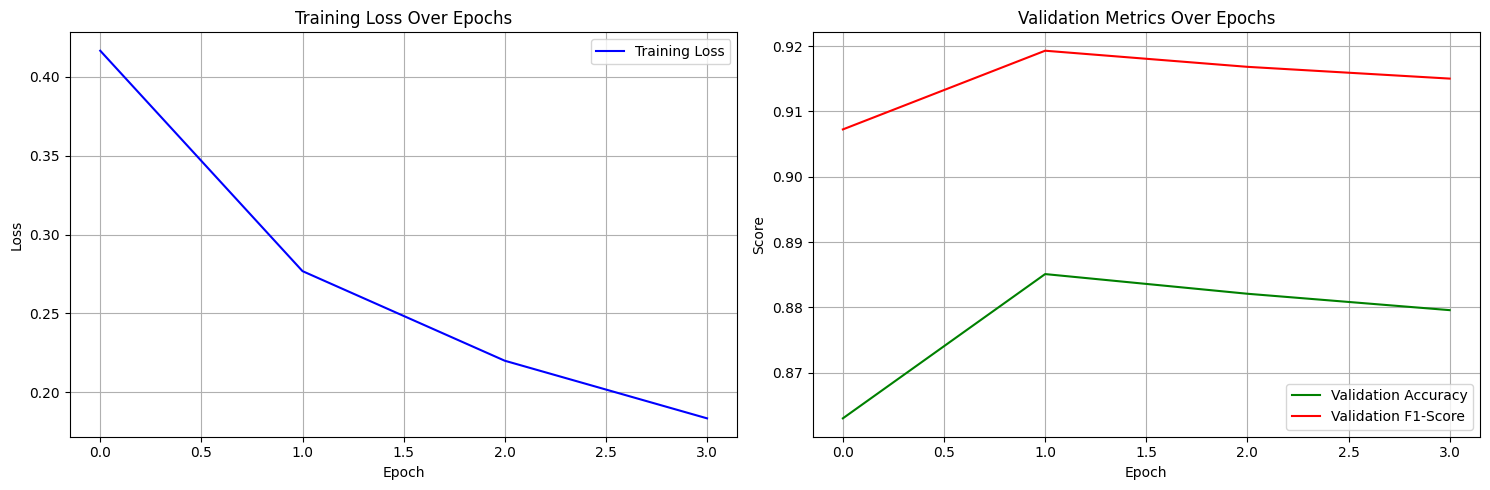

🎉 Training completed successfully!
📊 Final test results: {'accuracy': 0.8856282919488337, 'f1': 0.9193776520509194, 'precision': 0.9110021023125437, 'recall': 0.92790863668808}


In [20]:
def improved_train_distilbert_with_raw_data(df_raw, epochs=4, batch_size=16,
                                           learning_rate=2e-5, max_length=256,
                                           test_size=0.2, val_size=0.1):
    """
    Improved DistilBERT training using raw review samples directly.
    """
    print("🚀 Starting Improved DistilBERT Training with Raw Data...")

    if df_raw is None:
        raise ValueError("No raw dataset provided!")

    # Extract raw texts and labels directly (no preprocessing assumed)
    texts = df_raw['review'].tolist()  # Assuming column name is 'review'
    labels = df_raw['sentiment_label'].tolist()  # Assuming labels column

    print(f"📊 Training with {len(texts)} samples")
    print(f"📊 Label distribution: {pd.Series(labels).value_counts().to_dict()}")

    # First split: separate test set
    train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
        texts, labels, test_size=test_size, random_state=RANDOM_SEED, stratify=labels
    )

    # Second split: separate validation from training
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_val_texts, train_val_labels, test_size=val_size/(1-test_size),
        random_state=RANDOM_SEED, stratify=train_val_labels
    )

    print(f"📊 Split sizes:")
    print(f"  Training: {len(train_texts)}")
    print(f"  Validation: {len(val_texts)}")
    print(f"  Test: {len(test_texts)}")

    # Initialize tokenizer and model
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=2,
        dropout=0.3
    ).to(device)

    # Create datasets with raw texts
    train_dataset = SentimentDataset(train_texts, train_labels, tokenizer, max_length)
    val_dataset = SentimentDataset(val_texts, val_labels, tokenizer, max_length)
    test_dataset = SentimentDataset(test_texts, test_labels, tokenizer, max_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Setup optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )

    # Training tracking variables
    train_losses = []
    val_accuracies = []
    val_f1_scores = []
    best_val_f1 = 0
    best_model_state = None

    print(f"\n⚙️ Training Configuration:")
    print(f"  Epochs: {epochs}")
    print(f"  Batch Size: {batch_size}")
    print(f"  Learning Rate: {learning_rate}")
    print(f"  Max Length: {max_length}")
    print(f"  Total Steps: {total_steps}")
    print(f"  Warmup Steps: {int(0.1 * total_steps)}")

    # Training loop
    for epoch in range(epochs):
        print(f"\n📚 Epoch {epoch + 1}/{epochs}")

        model.train()
        total_train_loss = 0
        train_progress = tqdm(train_loader, desc=f"Training")

        for batch in train_progress:
            optimizer.zero_grad()

            outputs = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                labels=batch['labels'].to(device)
            )

            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            train_progress.set_postfix({
                'loss': f'{loss.item():.4f}',
                'lr': f'{scheduler.get_last_lr()[0]:.2e}'
            })

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_predictions = []
        val_true_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                outputs = model(
                    input_ids=batch['input_ids'].to(device),
                    attention_mask=batch['attention_mask'].to(device)
                )

                predictions = torch.argmax(outputs.logits, dim=-1)
                val_predictions.extend(predictions.cpu().numpy())
                val_true_labels.extend(batch['labels'].numpy())

        val_accuracy = accuracy_score(val_true_labels, val_predictions)
        val_f1 = f1_score(val_true_labels, val_predictions)
        val_precision = precision_score(val_true_labels, val_predictions)
        val_recall = recall_score(val_true_labels, val_predictions)

        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict().copy()
            print(f"🎯 New best model! Val F1: {val_f1:.4f}")

        print(f"Epoch {epoch + 1} Results:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Accuracy: {val_accuracy:.4f}")
        print(f"  Val F1: {val_f1:.4f}")
        print(f"  Val Precision: {val_precision:.4f}")
        print(f"  Val Recall: {val_recall:.4f}")

    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"\n✅ Loaded best model with Val F1: {best_val_f1:.4f}")

    # Final test evaluation
    print(f"\n🎯 Final Test Set Evaluation:")
    test_predictions = []
    test_true_labels = []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            outputs = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device)
            )

            predictions = torch.argmax(outputs.logits, dim=-1)
            test_predictions.extend(predictions.cpu().numpy())
            test_true_labels.extend(batch['labels'].numpy())

    test_accuracy = accuracy_score(test_true_labels, test_predictions)
    test_f1 = f1_score(test_true_labels, test_predictions)
    test_precision = precision_score(test_true_labels, test_predictions)
    test_recall = recall_score(test_true_labels, test_predictions)

    print(f"Final Test Results:")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print(f"  Test F1: {test_f1:.4f}")
    print(f"  Test Precision: {test_precision:.4f}")
    print(f"  Test Recall: {test_recall:.4f}")

    plot_training_curves(train_losses, val_accuracies, val_f1_scores)

    return model, tokenizer, {
        'train_losses': train_losses,
        'val_accuracies': val_accuracies,
        'val_f1_scores': val_f1_scores,
        'best_val_f1': best_val_f1,
        'test_results': {
            'accuracy': test_accuracy,
            'f1': test_f1,
            'precision': test_precision,
            'recall': test_recall
        },
        'test_texts': test_texts,
        'test_labels': test_true_labels,
        'test_predictions': test_predictions
    }


# MAIN EXECUTION - Run the training
if 'df_raw' in locals() and df_raw is not None:
    print("🎬 Starting training with raw data...")
    model, tokenizer, stats = improved_train_distilbert_with_raw_data(
        df_raw,
        epochs=4,
        batch_size=16,
        learning_rate=2e-5,
        max_length=256
    )

    print("🎉 Training completed successfully!")
    print(f"📊 Final test results: {stats['test_results']}")

    # Optional: Save the trained model (uncomment to save)
    # model.save_pretrained('./trained_distilbert_model_raw')
    # tokenizer.save_pretrained('./trained_distilbert_model_raw')
else:
    print("❌ No raw data found. Please load your raw dataset as 'df_raw'.")


🚀 Starting TF-IDF + Logistic Regression Sentiment Analysis
📥 Loading prepared dataset from 'steam_reviews.csv'...
✅ Dataset loaded successfully: 19931 reviews
📊 Sentiment distribution:
sentiment_label
1    14005
0     5926
Name: count, dtype: int64

🔤 Applying custom text preprocessing...
✅ Preprocessing complete.

📊 Data split: 15944 training samples, 3987 testing samples.

🔧 Starting hyperparameter tuning...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
✅ Hyperparameter tuning completed!
🎯 Best ROC AUC Score: 0.9059
🔧 Best Parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'tfidf__max_features': 15000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 3)}

📊 Evaluating model performance...

🎯 Model Performance on Test Set:
  Accuracy: 0.8483
  ROC AUC: 0.9149

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.81      0.76      1185
           1       0.91      0.87      0.89      2802

    accuracy  

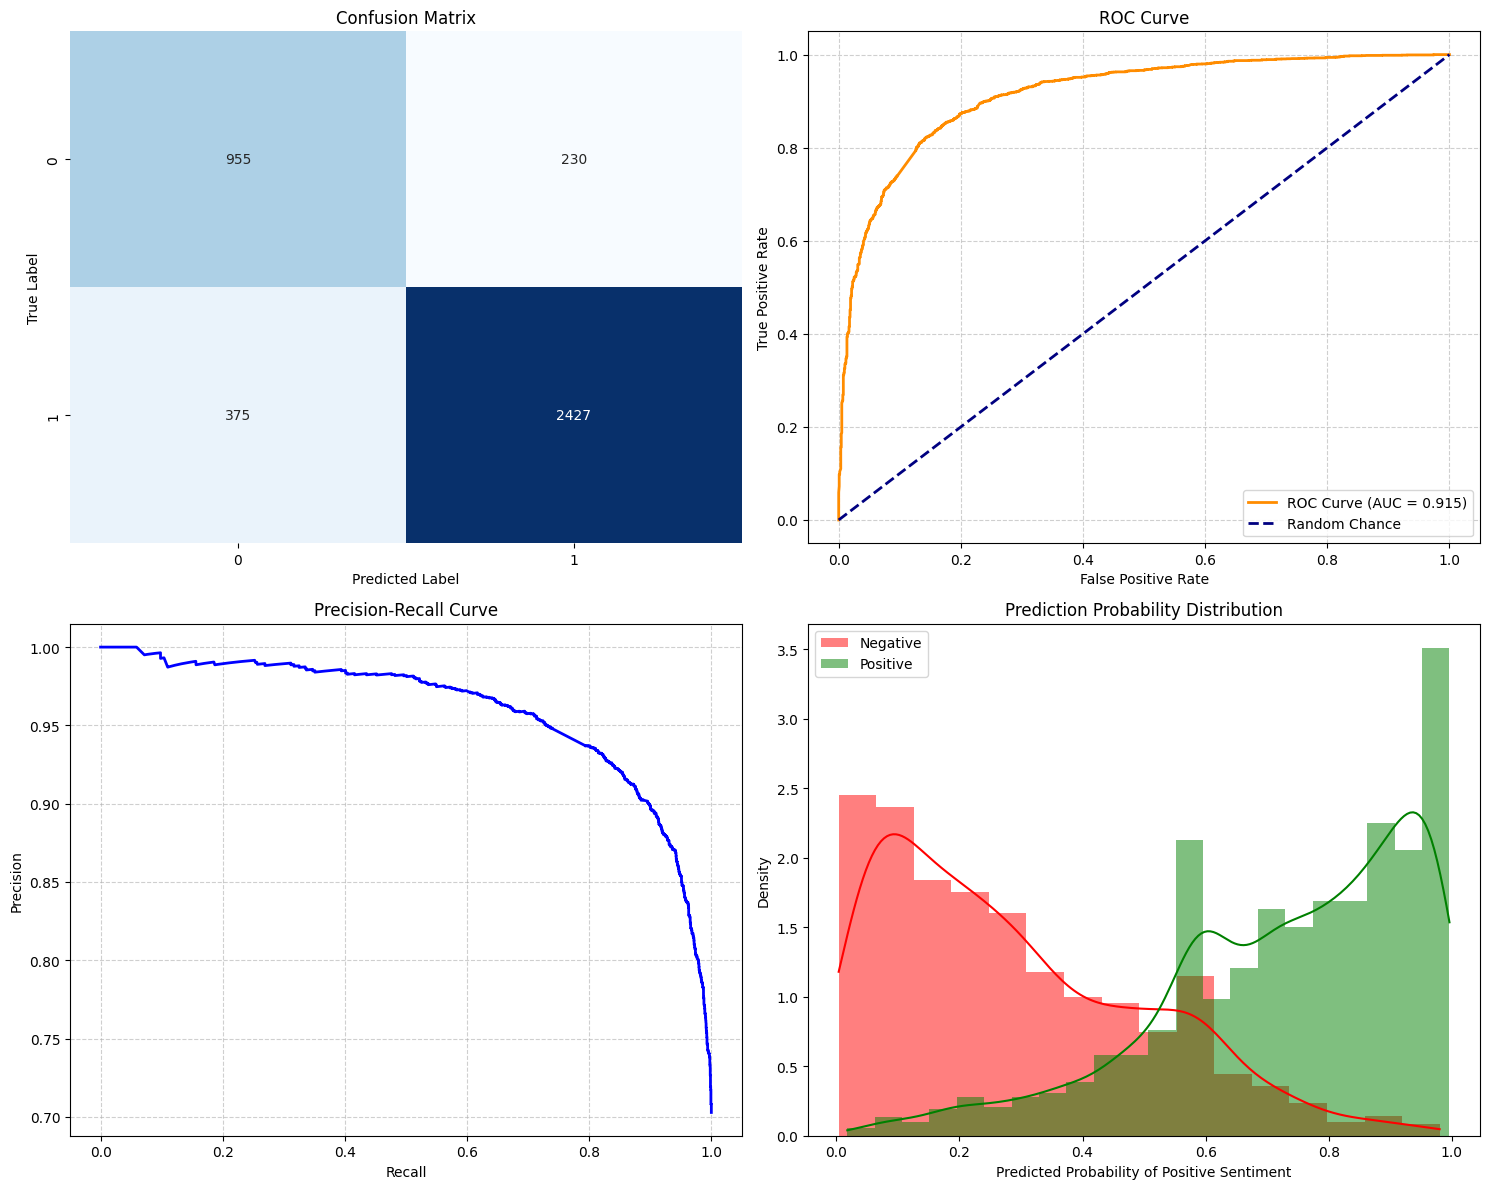


🔄 Cross-validation scores on Training Data:
  CV ROC AUC: 0.9059 (+/- 0.0038)

🔍 Top 20 Most Important Features:

📈 Top Positive Features (indicate 'Recommended'):
         feature  coefficient
6164       great     4.583719
339      amazing     4.378504
970         best     4.328229
686      awesome     4.188647
8197        love     3.651406
5933        good     3.542396
6182  great game     3.508759
4341         fun     2.966213
9284        nice     2.671633
3659   fantastic     2.446561

📉 Top Negative Features (indicate 'Not Recommended'):
        feature  coefficient
8773    modding    -4.453121
8809       mods    -3.990992
13848     trash    -3.834155
8829      money    -3.701580
1745   cheaters    -3.577635
14786     worst    -3.565614
11331    refund    -3.252881
7038        ing    -3.227666
5547    garbage    -3.171464
9670     openiv    -3.147899

🎉 Analysis completed successfully!
🎯 Final Test ROC AUC: 0.9149


In [21]:
# Tuned TF-IDF + Logistic Regression for Sentiment Analysis
# This version uses a manual TextPreprocessor and adjusts the TF-IDF pipeline accordingly.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                           roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.pipeline import Pipeline
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import warnings
import sys

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Download required NLTK data if not present
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Constants for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# --- 1. Text Preprocessing Class ---
class TextPreprocessor:
    """Advanced text preprocessing for sentiment analysis."""

    def __init__(self):
        # Using a set for faster stop word checking
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()

    def clean_text(self, text):
        """Clean and normalize raw text data."""
        if pd.isna(text):
            return ""

        # Convert to lowercase
        text = text.lower()
        # Remove URLs, user mentions, and hashtags
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'@\w+|#\w+', '', text)
        # Remove punctuation but keep some sentiment-relevant characters like '!' or '?'
        text = re.sub(r'[^\w\s!?.]', ' ', text)
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def preprocess_text(self, text):
        """Complete preprocessing pipeline: clean, tokenize, remove stop words."""
        cleaned_text = self.clean_text(text)

        # Tokenize, remove stop words, and filter for word length
        words = cleaned_text.split()
        processed_words = [word for word in words if word not in self.stop_words and len(word) > 2]

        # Note: Stemming is commented out as it can sometimes hurt performance with TF-IDF.
        # Uncomment the following line to apply stemming.
        # processed_words = [self.stemmer.stem(word) for word in processed_words]

        return ' '.join(processed_words)

# --- 2. Data Loading ---
def load_prepared_data(file_path='steam_reviews.csv'):
    """
    Load the prepared dataset from the specified file path.
    The script will exit if the file is not found or is missing required columns.
    """
    print(f"📥 Loading prepared dataset from '{file_path}'...")

    try:
        df = pd.read_csv(file_path)
        required_cols = ['review', 'recommendation']
        if not all(col in df.columns for col in required_cols):
            print(f"❌ FATAL ERROR: The CSV file '{file_path}' must contain the columns: {required_cols}")
            sys.exit(1)

        # Create sentiment labels (1 for 'Recommended', 0 for 'Not Recommended')
        df['sentiment_label'] = (df['recommendation'].str.strip() == 'Recommended').astype(int)
        df.dropna(subset=['review'], inplace=True)
        df['review'] = df['review'].astype(str)

        print(f"✅ Dataset loaded successfully: {len(df)} reviews")
        print("📊 Sentiment distribution:")
        print(df['sentiment_label'].value_counts())
        return df

    except FileNotFoundError:
        print(f"❌ FATAL ERROR: Dataset file not found at '{file_path}'.")
        print("Please ensure the CSV file is in the correct directory.")
        sys.exit(1)

# --- 3. Model Pipeline Creation (Modified for Preprocessed Text) ---
def create_tfidf_lr_pipeline():
    """Create optimized TF-IDF + Logistic Regression pipeline for preprocessed text."""

    # TF-IDF Vectorizer is configured for text that is already cleaned.
    # We set lowercase=False and stop_words=None because TextPreprocessor handled these steps.
    tfidf = TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        lowercase=False,          # MODIFIED: Text is already lowercase
        stop_words=None,          # MODIFIED: Stop words already removed
        strip_accents='ascii',
        token_pattern=r'\b[a-zA-Z]{2,}\b'
    )

    # Logistic Regression with optimized parameters
    lr = LogisticRegression(
        random_state=RANDOM_SEED,
        max_iter=1000,
        solver='liblinear',
        class_weight='balanced'
    )

    # Create the pipeline
    pipeline = Pipeline([
        ('tfidf', tfidf),
        ('classifier', lr)
    ])

    return pipeline

# --- 4. Hyperparameter Tuning ---
def tune_hyperparameters(X_train, y_train, cv_folds=5):
    """Perform hyperparameter tuning with GridSearchCV."""
    print("\n🔧 Starting hyperparameter tuning...")

    pipeline = create_tfidf_lr_pipeline()

    # A simplified grid for faster tuning. Expand if more computational power is available.
    param_grid_simple = {
        'tfidf__max_features': [10000, 15000],
        'tfidf__ngram_range': [(1, 2), (1, 3)],
        'tfidf__min_df': [2, 3],
        'classifier__C': [1.0, 10.0],
        'classifier__penalty': ['l2']
    }

    grid_search = GridSearchCV(
        pipeline, param_grid_simple, cv=cv_folds,
        scoring='roc_auc', n_jobs=-1, verbose=1
    )

    grid_search.fit(X_train, y_train)

    print("✅ Hyperparameter tuning completed!")
    print(f"🎯 Best ROC AUC Score: {grid_search.best_score_:.4f}")
    print(f"🔧 Best Parameters: {grid_search.best_params_}")

    return grid_search.best_estimator_, grid_search.best_params_

# --- 5. Model Evaluation and Visualization ---
def evaluate_model(model, X_test, y_test, X_train, y_train):
    """Comprehensive model evaluation and visualization."""
    print("\n📊 Evaluating model performance...")

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print("\n🎯 Model Performance on Test Set:")
    print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"  ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    print("\n📋 Classification Report:")
    print(classification_report(y_test, y_pred))

    plot_evaluation_results(y_test, y_pred, y_pred_proba)

    print("\n🔄 Cross-validation scores on Training Data:")
    cv_auc_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"  CV ROC AUC: {cv_auc_scores.mean():.4f} (+/- {cv_auc_scores.std() * 2:.4f})")

    return {'accuracy': accuracy_score(y_test, y_pred), 'roc_auc': roc_auc_score(y_test, y_pred_proba)}

def plot_evaluation_results(y_true, y_pred, y_pred_proba):
    """Plot confusion matrix, ROC curve, and other evaluation visuals."""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=False)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')
    ax2.legend(loc='lower right')
    ax2.grid(True, linestyle='--', alpha=0.6)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    ax3.plot(recall, precision, color='blue', lw=2)
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.set_title('Precision-Recall Curve')
    ax3.grid(True, linestyle='--', alpha=0.6)

    # Prediction Probability Distribution
    sns.histplot(y_pred_proba[y_true == 0], color="red", label='Negative', ax=ax4, kde=True, stat="density", linewidth=0)
    sns.histplot(y_pred_proba[y_true == 1], color="green", label='Positive', ax=ax4, kde=True, stat="density", linewidth=0)
    ax4.set_xlabel('Predicted Probability of Positive Sentiment')
    ax4.set_ylabel('Density')
    ax4.set_title('Prediction Probability Distribution')
    ax4.legend()

    plt.tight_layout()
    plt.show()

def analyze_feature_importance(model, top_n=20):
    """Analyze and display most important features for sentiment."""
    if not isinstance(model, Pipeline):
        print("Feature importance can only be analyzed for the full pipeline model.")
        return None

    print(f"\n🔍 Top {top_n} Most Important Features:")

    coef = model.named_steps['classifier'].coef_[0]
    feature_names = model.named_steps['tfidf'].get_feature_names_out()

    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coef
    }).sort_values('coefficient', ascending=False)

    top_positive = feature_importance.head(top_n // 2)
    top_negative = feature_importance.tail(top_n // 2).sort_values('coefficient', ascending=True)

    print("\n📈 Top Positive Features (indicate 'Recommended'):")
    print(top_positive)

    print("\n📉 Top Negative Features (indicate 'Not Recommended'):")
    print(top_negative)
    return feature_importance

# --- 6. Main Execution Function ---
def main():
    """Main function to run the complete analysis pipeline."""
    print("🚀 Starting TF-IDF + Logistic Regression Sentiment Analysis")
    print("=" * 60)

    # Step 1: Load data
    df = load_prepared_data('steam_reviews.csv')

    # Step 2: Manually preprocess the text data
    print("\n🔤 Applying custom text preprocessing...")
    preprocessor = TextPreprocessor()
    df['processed_review'] = df['review'].apply(preprocessor.preprocess_text)
    print("✅ Preprocessing complete.")

    # Step 3: Define features (X) and target (y) using the processed text
    X = df['processed_review'].values
    y = df['sentiment_label'].values

    # Step 4: Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
    )
    print(f"\n📊 Data split: {len(X_train)} training samples, {len(X_test)} testing samples.")

    # Step 5: Train model with hyperparameter tuning
    best_model, best_params = tune_hyperparameters(X_train, y_train)

    # Step 6: Evaluate the best model
    results = evaluate_model(best_model, X_test, y_test, X_train, y_train)

    # Step 7: Analyze feature importance
    feature_importance = analyze_feature_importance(best_model)

    print("\n🎉 Analysis completed successfully!")
    print("=" * 60)
    print(f"🎯 Final Test ROC AUC: {results['roc_auc']:.4f}")

    return best_model, results, feature_importance

# --- Run the analysis ---
if __name__ == "__main__":
    model, results, feature_importance = main()


<ipython-input-2-c663a9d63d02>:28: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


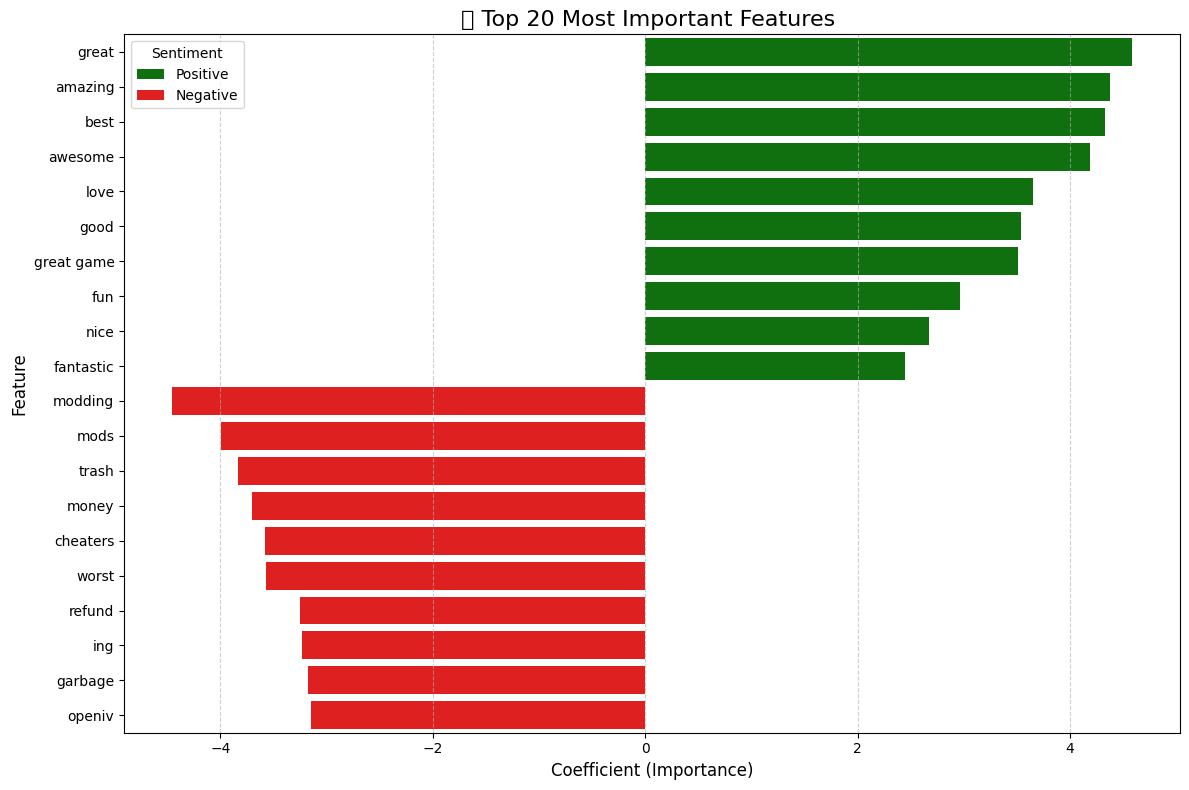

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
top_positive = pd.DataFrame({
    'feature': ['great', 'amazing', 'best', 'awesome', 'love', 'good', 'great game', 'fun', 'nice', 'fantastic'],
    'coefficient': [4.583719, 4.378504, 4.328229, 4.188647, 3.651406, 3.542396, 3.508759, 2.966213, 2.671633, 2.446561],
    'sentiment': ['Positive']*10
})

top_negative = pd.DataFrame({
    'feature': ['modding', 'mods', 'trash', 'money', 'cheaters', 'worst', 'refund', 'ing', 'garbage', 'openiv'],
    'coefficient': [-4.453121, -3.990992, -3.834155, -3.701580, -3.577635, -3.565614, -3.252881, -3.227666, -3.171464, -3.147899],
    'sentiment': ['Negative']*10
})

# Combine data
top_features = pd.concat([top_positive, top_negative], axis=0)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=top_features, x='coefficient', y='feature', hue='sentiment', palette={'Positive': 'green', 'Negative': 'red'})
plt.title('🔍 Top 20 Most Important Features ', fontsize=16)
plt.xlabel('Coefficient (Importance)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()


<ipython-input-3-a7f993301540>:22: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


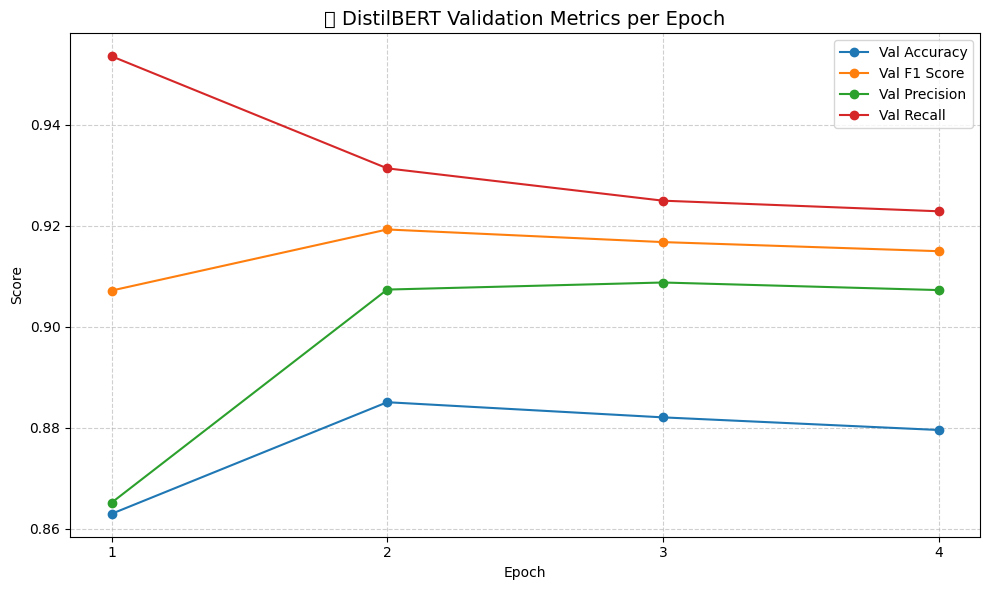

In [3]:
import matplotlib.pyplot as plt

# Metrics across epochs
epochs = [1, 2, 3, 4]
val_accuracy = [0.8630, 0.8851, 0.8821, 0.8796]
val_f1 = [0.9072, 0.9193, 0.9168, 0.9150]
val_precision = [0.8652, 0.9074, 0.9088, 0.9073]
val_recall = [0.9536, 0.9314, 0.9250, 0.9229]

plt.figure(figsize=(10, 6))
plt.plot(epochs, val_accuracy, label='Val Accuracy', marker='o')
plt.plot(epochs, val_f1, label='Val F1 Score', marker='o')
plt.plot(epochs, val_precision, label='Val Precision', marker='o')
plt.plot(epochs, val_recall, label='Val Recall', marker='o')

plt.title('📊 DistilBERT Validation Metrics per Epoch', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


<ipython-input-9-7daf97dcb698>:25: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


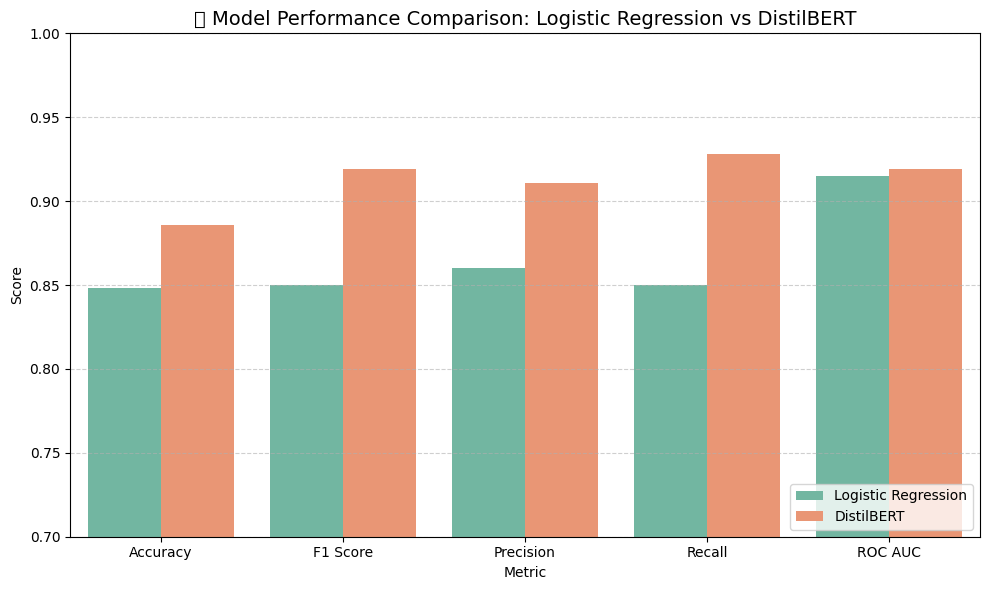

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Model performance data from logs
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC AUC']

lr_scores = [0.8483, 0.85, 0.86, 0.85, 0.9149]
bert_scores = [0.8856, 0.9194, 0.9110, 0.9279, 0.9194]

comparison_df = pd.DataFrame({
    'Metric': metrics,
    'Logistic Regression': lr_scores,
    'DistilBERT': bert_scores
})

comparison_df = pd.melt(comparison_df, id_vars='Metric', var_name='Model', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df, x='Metric', y='Score', hue='Model', palette='Set2')
plt.title("📊 Model Performance Comparison: Logistic Regression vs DistilBERT", fontsize=14)
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


<ipython-input-6-dad08fe52249>:15: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


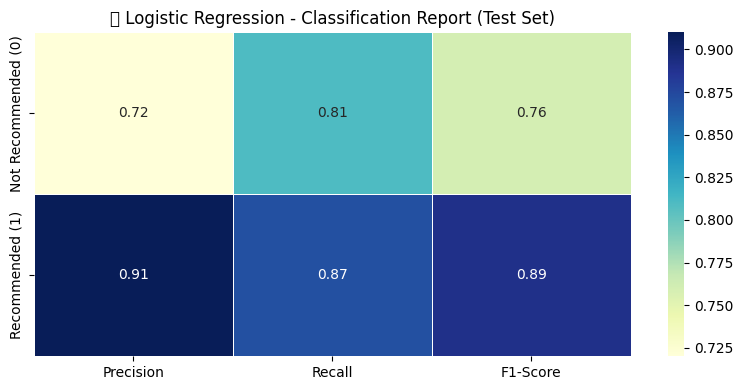

In [6]:
import numpy as np

# From classification report
report_data = {
    'Precision': [0.72, 0.91],
    'Recall': [0.81, 0.87],
    'F1-Score': [0.76, 0.89]
}

report_df = pd.DataFrame(report_data, index=['Not Recommended (0)', 'Recommended (1)'])

plt.figure(figsize=(8, 4))
sns.heatmap(report_df, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)
plt.title("📋 Logistic Regression - Classification Report (Test Set)")
plt.tight_layout()
plt.show()


<ipython-input-11-04ba49d8ef7b>:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


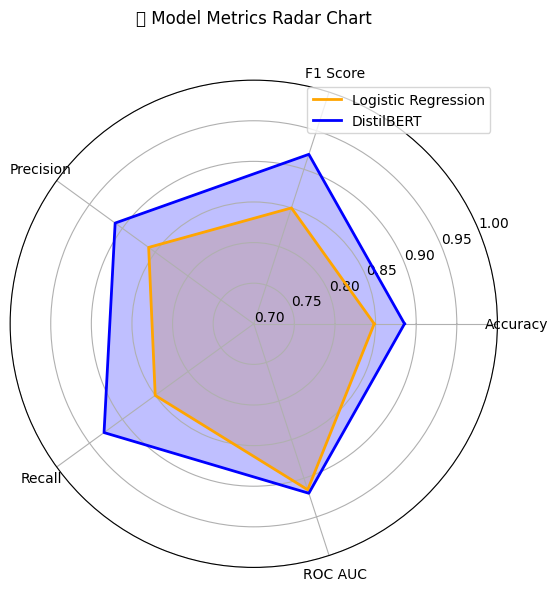

In [11]:
import numpy as np

labels = np.array(['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC AUC'])
lr = np.array([0.8483, 0.85, 0.86, 0.85, 0.9149])
bert = np.array([0.8856, 0.9194, 0.9110, 0.9279, 0.9194])

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
lr = np.concatenate((lr, [lr[0]]))
bert = np.concatenate((bert, [bert[0]]))
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

ax.plot(angles, lr, label='Logistic Regression', color='orange', linewidth=2)
ax.fill(angles, lr, alpha=0.25, color='orange')

ax.plot(angles, bert, label='DistilBERT', color='blue', linewidth=2)
ax.fill(angles, bert, alpha=0.25, color='blue')

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title('📊 Model Metrics Radar Chart', y=1.1)
ax.set_ylim(0.7, 1.0)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


<ipython-input-12-ea410fff55a5>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Score', data=df_metrics, palette='coolwarm')
<ipython-input-12-ea410fff55a5>:17: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


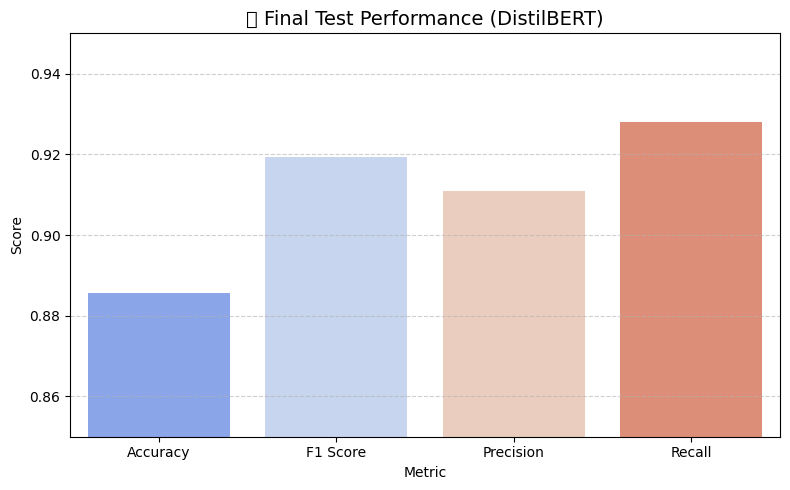

In [12]:
import seaborn as sns
import pandas as pd

# Final test performance
metrics = {
    'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'Score': [0.8856, 0.9194, 0.9110, 0.9279]
}

df_metrics = pd.DataFrame(metrics)

plt.figure(figsize=(8, 5))
sns.barplot(x='Metric', y='Score', data=df_metrics, palette='coolwarm')
plt.ylim(0.85, 0.95)
plt.title('🎯 Final Test Performance (DistilBERT)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


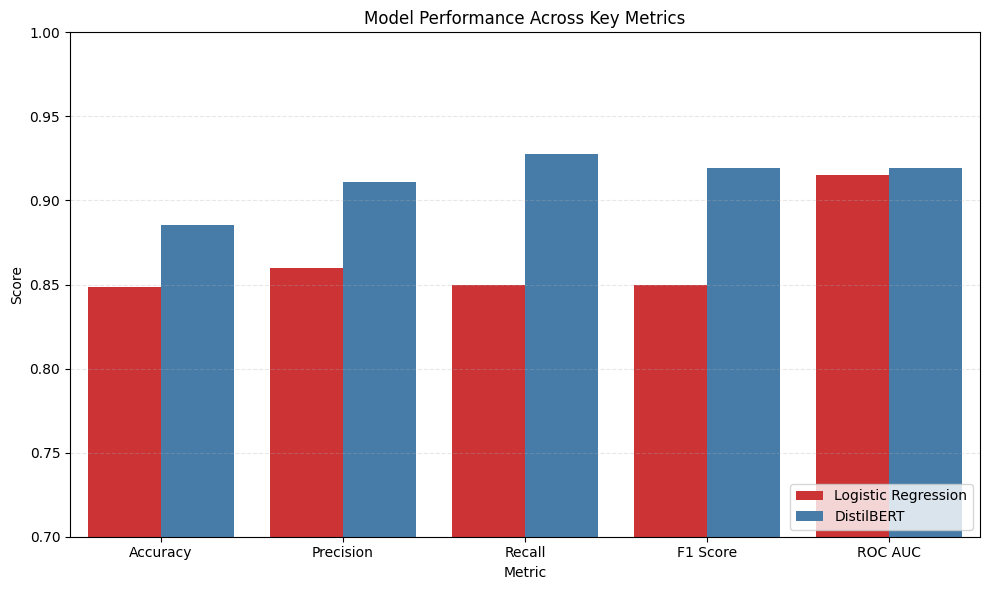

NameError: name 'y_test' is not defined

<Figure size 800x600 with 0 Axes>

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
lr_vals = [0.8483, 0.8600, 0.8500, 0.8500, 0.9149]
bert_vals = [0.8856, 0.9110, 0.9279, 0.9194, 0.9194]

df = pd.DataFrame({
    'Metric': metrics * 2,
    'Score': lr_vals + bert_vals,
    'Model': ['Logistic Regression']*5 + ['DistilBERT']*5
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=df, palette='Set1')
plt.title('Model Performance Across Key Metrics')
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(8, 6))
# Logistic Regression
prec_lr, rec_lr, _ = precision_recall_curve(y_test, lr_probs)
plt.plot(rec_lr, prec_lr, label='Logistic Regression', color='orange')

# DistilBERT
prec_bert, rec_bert, _ = precision_recall_curve(y_test, bert_probs)
plt.plot(rec_bert, prec_bert, label='DistilBERT', color='green')

plt.title('Precision-Recall Curve Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



In [17]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(8, 6))
# Logistic Regression
prec_lr, rec_lr, _ = precision_recall_curve(y_test, lr_probs)
plt.plot(rec_lr, prec_lr, label='Logistic Regression', color='orange')

# DistilBERT
prec_bert, rec_bert, _ = precision_recall_curve(y_test, bert_probs)
plt.plot(rec_bert, prec_bert, label='DistilBERT', color='green')

plt.title('Precision-Recall Curve Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


NameError: name 'y_test' is not defined

<Figure size 800x600 with 0 Axes>